# Colapse all simulation into a unique .feather file

In [1]:
import glob, os
import pandas as pd
import numpy as np
from scipy.stats import ecdf, wasserstein_distance


df_complete_file = 'df_complete_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_complete_file) ):
    print(f'{df_complete_file} already exists. Reading it.')
    # df_all = pd.read_feather(df_complete_file)
else:
    print(f'{df_complete_file} does not exists. Generating it.')
    data_files = glob.glob('../output_SA_ex1/SummaryFile_*.feather')
    df_all = pd.concat((pd.read_feather(file) for file in data_files), ignore_index=True)
    df_all.to_feather(df_complete_file)

params_list = ['cycle_tumor_base','necrosis_tumor_base','tumor2motile_base','cycle_motile_base','necrosis_motile_base',
               'cycle_tumor_sat','cycle_tumor_hfm','cycle_tumor_hp',
                   'mechano_tumor_hfm','mechano_tumor_hp',
                   'necrosis_tumor_hfm','necrosis_tumor_hp',
                   'tumor2motile_hfm','tumor2motile_hp',
                   'cycle_motile_sat', 'cycle_motile_hfm', 'cycle_motile_hp',
                   'mechano_motile_hfm', 'mechano_motile_hp',
                   'necrosis_motile_hfm', 'necrosis_motile_hp',
                   'motile2tumor_sat', 'motile2tumor_hfm', 'motile2tumor_hp']
# 1,167,650 rows = 193 samples * 50 repplicates * 121 time points

df_complete_ex1.feather already exists. Reading it.


# Define the QoIs: AUC of each mean population, distribution of cell distance from the center at the last time

- Population: store the population of each cell type over time.
    - Summary over time and replicates: Area under curve (AUC) of the average populations.
- Invasion: Distance of cells from the center - provides insights into the spatial distribution and invasion characteristics of the cells.
    - Summary over time and replicates: Pooling the distances from replicates and calculate the Wassertein distance between tumor and motile.


In [2]:
df_qoi_file = 'df_qoi_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
df_summary_file = 'df_summary_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_summary_file) & os.path.exists(df_qoi_file) ):
    print(f'{df_summary_file} and {df_qoi_file} already exists. Reading it.')
    df_summary = pd.read_feather(df_summary_file)
    df_qoi = pd.read_feather(df_qoi_file)
else:
    print(f'{df_summary_file} or {df_qoi_file} does not exists. Generating it.')
    # Calculate the AUC for each sample and replicate
    def calculate_auc_wassertein_dist(group):
        auc_values = {}
        for col in ['tumor_live', 'tumor_dead', 'motile_live', 'motile_dead']: # QoI columns of cell population  
            mask_notna = group[col].notna()  
            auc_values[f'AUC_{col}'] = np.trapz(group[col][mask_notna], group['time'][mask_notna])
        wasserstein_values = {}
        subgroup = group[group['time'] == 7200.0] # select the last time point
        emp_tumor_cdf = ecdf(subgroup['dist_tumor_live'].values[0])
        emp_motile_cdf = ecdf(subgroup['dist_motile_live'].values[0])
        wasserstein_values['Wasserstein_dist'] = wasserstein_distance(emp_tumor_cdf.cdf.quantiles, emp_motile_cdf.cdf.quantiles, emp_tumor_cdf.cdf.probabilities, emp_motile_cdf.cdf.probabilities)
        return pd.Series({**auc_values, **wasserstein_values})

    # Group by 'SampleID' and 'replicate' then calculate AUC and Wassertein distance for each QOI - row dimension of samples x replicates
    df_qoi = df_all.groupby(['sample', 'replicate']).apply(calculate_auc_wassertein_dist).reset_index()
    # Add the parameter values to the QoI dataframe
    df_qoi = df_qoi.merge(df_all[['sample', 'replicate'] + params_list], on=['sample', 'replicate'], how='left').drop_duplicates().reset_index(drop=True)
    
    # Calculate the mean and standard deviation of the QoI for each sample
    df_summary = df_qoi.groupby(['sample']).agg({'AUC_tumor_live': ['mean', 'std'], 'AUC_tumor_dead': ['mean', 'std'], 'AUC_motile_live': ['mean', 'std'], 'AUC_motile_dead': ['mean', 'std'], 'Wasserstein_dist': ['mean', 'std']}).reset_index()
    df_summary.columns = ['_'.join(col) if col[1] else col[0] for col in df_summary.columns]
    # Add the parameter values to the summary dataframe
    df_summary = df_summary.merge(df_qoi[['sample'] + params_list], on=['sample'], how='left').drop_duplicates().reset_index(drop=True)
    
    
    # Save the dataframes to feather files
    df_qoi.to_feather(df_qoi_file)
    df_summary.to_feather(df_summary_file)

print(df_qoi.shape)
print(df_summary.shape)
df_summary

df_summary_ex1.feather and df_qoi_ex1.feather already exists. Reading it.
(9650, 31)
(193, 35)


,sample,AUC_tumor_live_mean,AUC_tumor_live_std,AUC_tumor_dead_mean,AUC_tumor_dead_std,AUC_motile_live_mean,AUC_motile_live_std,AUC_motile_dead_mean,AUC_motile_dead_std,Wasserstein_dist_mean,...,cycle_motile_sat,cycle_motile_hfm,cycle_motile_hp,mechano_motile_hfm,mechano_motile_hp,necrosis_motile_hfm,necrosis_motile_hp,motile2tumor_sat,motile2tumor_hfm,motile2tumor_hp
0,0,12599872.8,116226.481580,2577283.2,82903.983544,1609754.4,54394.713622,878388.6,63023.645385,119.101705,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
1,1,12566227.2,114297.665983,2568325.8,60793.441311,1595599.2,58689.117471,867574.8,68904.424497,116.733460,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
2,2,12626206.8,183060.372761,2577936.0,71730.670240,1618795.8,72014.418712,889663.2,61761.456425,118.669388,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
3,3,12546777.6,163867.722022,2548109.4,72369.317983,1584557.4,58545.271365,871987.8,64394.402637,117.502375,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
4,4,12625597.8,164921.787973,2590981.2,96639.788097,1608911.4,64826.358837,888713.4,57028.311322,117.269028,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,188,12603148.8,149210.095307,2561312.4,75184.198094,1639434.6,60838.213562,875599.2,76444.551276,118.999942,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.4
189,189,12626967.6,113817.214662,2586513.0,59900.186339,1570371.0,49586.715603,861663.0,63764.228352,115.344907,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,7.2
190,190,12547218.0,141977.212199,2533656.6,75920.373959,1651852.2,70560.787899,904120.8,53342.936064,119.033725,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.8
191,191,12697405.8,158066.920446,2632551.0,81309.140743,1548094.2,59991.939870,832729.2,55393.937849,114.366868,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,6.4


Sample with reference parameters:  [7.20e-04 2.80e-03 1.00e-03 7.20e-04 2.80e-03 7.20e-03 2.15e+01 4.00e+00
 2.50e-01 3.00e+00 3.75e+00 8.00e+00 6.75e+00 8.00e+00 7.20e-03 2.15e+01
 4.00e+00 2.50e-01 3.00e+00 3.75e+00 8.00e+00 5.00e-03 6.75e+00 8.00e+00]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4318: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


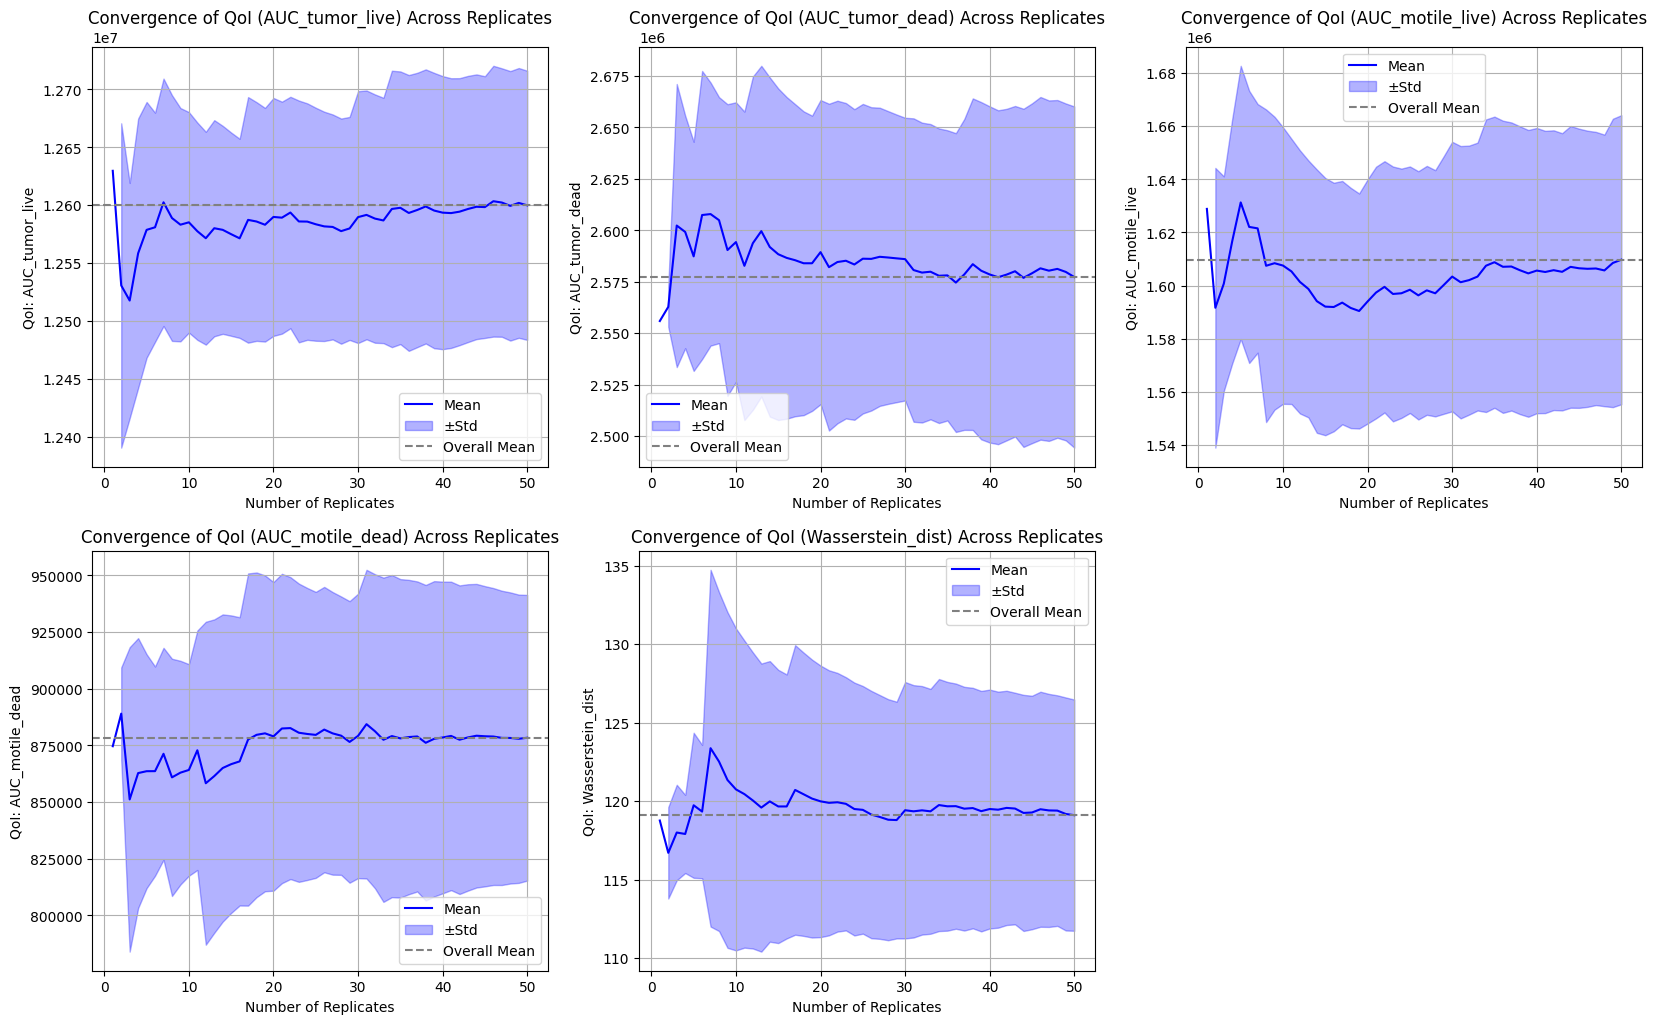

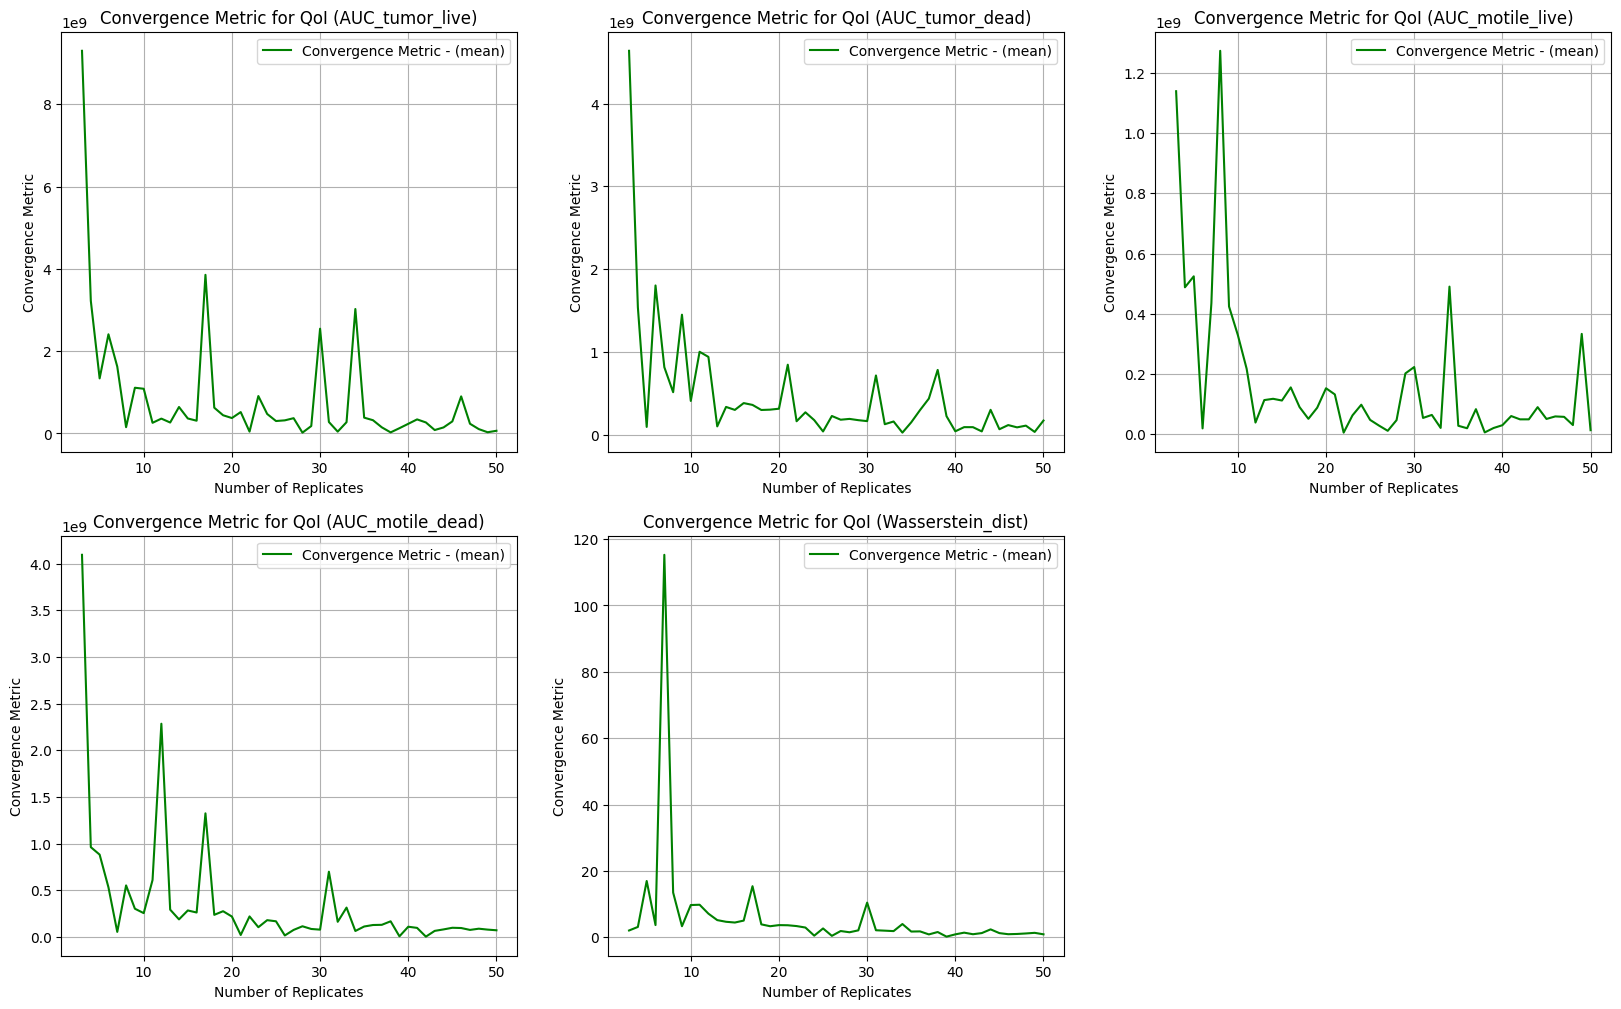

In [3]:
import matplotlib.pyplot as plt
from convergence_analysis import mean_variance_convergence, test_convergence, bootstrap_convergence

sample_ref = 0 # Sample with reference parameters
print('Sample with reference parameters: ', df_summary.iloc[sample_ref][params_list].values)
QoIs_list = ['AUC_tumor_live', 'AUC_tumor_dead', 'AUC_motile_live', 'AUC_motile_dead', 'Wasserstein_dist']
figure1, axes = plt.subplots(2, 3, figsize=(20, 12))
figure2, axes2 = plt.subplots(2, 3, figsize=(20, 12))
for qoi, ax, ax2 in zip(QoIs_list, axes.flatten(), axes2.flatten()):
    data = df_qoi.loc[ df_qoi['sample'] == sample_ref][qoi].values
    # Calculate running mean and variance for the QoI
    running_means, running_var = mean_variance_convergence(data)
    running_stds = np.sqrt(running_var)
    # Test convergence using the auto-selected method
    window_size = 5
    convergence_metric, method_selected = test_convergence(data, method='mean', window_size=window_size)
    # Test convergence using bootstrapping
    bootstrap_metric = bootstrap_convergence(data)
    # Plot the running mean and standard deviation
    x = np.arange(1, len(data) + 1)
    ax.plot(x, running_means, label='Mean', color='b')
    ax.fill_between(x, running_means - running_stds, running_means + running_stds, alpha=0.3, label='±Std', color='b')
    ax.axhline(np.mean(data), color='gray', linestyle='--', label='Overall Mean')
    ax.set_xlabel('Number of Replicates')
    ax.set_ylabel(f'QoI: {qoi}')
    ax.set_title(f'Convergence of QoI ({qoi}) Across Replicates')
    ax.grid()
    ax.legend()
    # Plot the convergence metric
    ax2.plot(x[1:], convergence_metric, label=f'Convergence Metric - ({method_selected})', color='green')
    # ax2_y2 = ax2.twinx()
    # ax2_y2.plot(x, bootstrap_metric, label='Bootstrapped Variability', color='red')
    # ax2_y2.set_ylabel('Bootstrapped Variability')
    ax2.set(xlabel='Number of Replicates', ylabel='Convergence Metric',title=f'Convergence Metric for QoI ({qoi})')
    ax2.grid()
    ax2.legend()
axes[1, 2].remove()
axes2[1, 2].remove()
plt.show()

# Local sensitivity analysis: 
Give $\theta^\star$ as the reference parameter set, we added a multiplicative perturbation $\delta$, which
$$\theta_i = \theta^\star \times (1\pm \delta), \quad \delta = \{0.01, 0.05, 0.1, 0.2\}$$

Relative sensitivity (Elasticity -  For every $1\%$ change in $\theta_i$, the output changes by $\bar{S}_{\theta_i} \times 1\%$:

$$\bar{S}_{\theta_i} = \dfrac{f(\theta_i)-f(\theta^\star)}{f(\theta^\star)}\cdot \dfrac{\theta^\star}{\theta_i - \theta^\star}$$

- $S>0:$ As the parameter increases, the output also increases.
- $S<0:$ As the parameter increases, the output decreases.
- $S=0:$ The output is insensitive to changes in the parameter.
- $∣S∣≫1:$ The output is highly sensitive to the parameter; small changes in the parameter will cause large changes in the output.
- $∣S∣≪1:$ The output is relatively insensitive to the parameter; large changes in the parameter will have little effect on the output.

In [4]:
# Calculate the sensitivity index
QoIs_list = [qoi+'_mean' for qoi in QoIs_list]
# Function to calculate SI using
def calculate_SI_multiple():
    sensitivity_analysis_dic = {}
    # Calculate the delta of parameters
    non_zero_values = []; non_zero_params= []
    relative_change_params = (df_summary[params_list] - df_summary.iloc[sample_ref][params_list].values) / np.where(df_summary.iloc[sample_ref][params_list].values != 0, df_summary.iloc[sample_ref][params_list].values, 1)
    for index, row in relative_change_params.iterrows():
        # First index is the reference sample - include the value 1 and skip it
        if index == sample_ref: non_zero_values.append(1); non_zero_params.append(params_list[0]); continue
        # Get the non-zero values in the row
        non_zero_row_values = row[row != 0.0]
        # Check if there is exactly one non-zero value
        if len(non_zero_row_values) == 1: non_zero_values.append(non_zero_row_values.iloc[0])
        else: raise ValueError(f"Row {index} contains more than one non-zero value or all values are zero. Non zero: {non_zero_row_values} - Row: {row.values}")
        # Parameter name with non-zero value
        non_zero_params.append(non_zero_row_values.index[0])
    relative_change_params_1d = pd.DataFrame(non_zero_values, columns=['NonZeroValues'])
    sensitivity_analysis_dic['SA_parameter'] = np.array(non_zero_params)
    sensitivity_analysis_dic['SA_delta'] = relative_change_params_1d.to_numpy()[:,0].round(2)
    # Calculate the delta of QoIs
    absolute_change_qois = df_summary[QoIs_list] - df_summary.iloc[sample_ref][QoIs_list].values
    relative_change_qois = absolute_change_qois / np.where(df_summary.iloc[sample_ref][QoIs_list].values != 0, df_summary.iloc[sample_ref][QoIs_list].values, 1)
    absolute_change_params = sensitivity_analysis_dic['SA_delta'] * df_summary.iloc[sample_ref][ sensitivity_analysis_dic['SA_parameter'] ].to_numpy()
    for id_qoi, qoi in enumerate(QoIs_list): 
        sensitivity_analysis_dic[f'SI_{qoi}'] = relative_change_qois.to_numpy()[:,id_qoi]/sensitivity_analysis_dic['SA_delta']
        parameter_name = sensitivity_analysis_dic['SA_parameter']
        sensitivity_analysis_dic[f'Abs_SI_{qoi}'] = absolute_change_qois.to_numpy()[:,id_qoi]/absolute_change_params
    
    # Change the delta of reference value to 0 and label it as reference
    sensitivity_analysis_dic['SA_delta'][0] = 0
    sensitivity_analysis_dic['SA_parameter'][0] = 'Reference'
    return pd.DataFrame(sensitivity_analysis_dic)

# Group by 'Sample_ID' then calculate AUC for each QOI - row dimension of samples
df_SA = calculate_SI_multiple() # calculate the AUC for each QOI
df_SA = pd.concat([df_summary['sample'], df_SA], axis=1)

# Print the sensitivity index
for qoi in QoIs_list:
    sample_lowest_qoi = df_summary.iloc[df_summary[qoi].idxmin()]['sample']; sample_highest_qoi = df_summary.iloc[df_summary[qoi].idxmax()]['sample']
    sample_lowest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmin()]['sample']; sample_highest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmax()]['sample']
    print(f"QoI: {qoi}")
    print(f"\t lowest and highest QoI: {sample_lowest_qoi} ({df_SA.iloc[int(sample_lowest_qoi)]['SA_parameter']}) and {sample_highest_qoi} ({df_SA.iloc[int(sample_highest_qoi)]['SA_parameter']})")
    print(f"\t lowest and highest SI: {sample_lowest_si} ({df_SA.iloc[int(sample_lowest_si)]['SA_parameter']}) and {sample_highest_si} ({df_SA.iloc[int(sample_highest_si)]['SA_parameter']})\n")
df_SA

QoI: AUC_tumor_live_mean
	 lowest and highest QoI: 184.0 (motile2tumor_hfm) and 55.0 (cycle_tumor_hfm)
	 lowest and highest SI: 50 (cycle_tumor_hfm) and 65 (mechano_tumor_hfm)

QoI: AUC_tumor_dead_mean
	 lowest and highest QoI: 87.0 (necrosis_tumor_hfm) and 88.0 (necrosis_tumor_hfm)
	 lowest and highest SI: 90 (necrosis_tumor_hp) and 81 (necrosis_tumor_hfm)

QoI: AUC_motile_live_mean
	 lowest and highest QoI: 103.0 (tumor2motile_hfm) and 184.0 (motile2tumor_hfm)
	 lowest and highest SI: 82 (necrosis_tumor_hfm) and 184 (motile2tumor_hfm)

QoI: AUC_motile_dead_mean
	 lowest and highest QoI: 159.0 (necrosis_motile_hfm) and 160.0 (necrosis_motile_hfm)
	 lowest and highest SI: 81 (necrosis_tumor_hfm) and 156 (necrosis_motile_hfm)

QoI: Wasserstein_dist_mean
	 lowest and highest QoI: 183.0 (motile2tumor_hfm) and 103.0 (tumor2motile_hfm)
	 lowest and highest SI: 154 (necrosis_motile_hfm) and 17 (tumor2motile_base)



,sample,SA_parameter,SA_delta,SI_AUC_tumor_live_mean,Abs_SI_AUC_tumor_live_mean,SI_AUC_tumor_dead_mean,Abs_SI_AUC_tumor_dead_mean,SI_AUC_motile_live_mean,Abs_SI_AUC_motile_live_mean,SI_AUC_motile_dead_mean,Abs_SI_AUC_motile_dead_mean,SI_Wasserstein_dist_mean,Abs_SI_Wasserstein_dist_mean
0,0,Reference,0.00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
1,1,cycle_tumor_base,-0.01,0.267031,4.673000e+09,0.347552,1.244083e+09,0.879339,1.966000e+09,1.231095,1.501917e+09,1.988422,328922.910214
2,2,cycle_tumor_base,0.01,0.209002,3.657500e+09,0.025329,9.066667e+07,0.561663,1.255750e+09,1.283555,1.565917e+09,-0.362981,-60043.987047
3,3,cycle_tumor_base,-0.05,0.084279,1.474867e+09,0.226392,8.103833e+08,0.313054,6.999167e+08,0.145740,1.778000e+08,0.268565,44425.837306
4,4,cycle_tumor_base,0.05,0.040834,7.145833e+08,0.106298,3.805000e+08,-0.010474,-2.341667e+07,0.235085,2.868000e+08,-0.307750,-50907.683727
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,188,motile2tumor_hp,0.05,0.005200,8.190000e+03,-0.123935,-3.992700e+04,0.368754,7.420050e+04,-0.063512,-6.973500e+03,-0.017088,-0.254406
189,189,motile2tumor_hp,-0.10,-0.021504,-3.386850e+04,-0.035812,-1.153725e+04,0.244655,4.922925e+04,0.190412,2.090700e+04,0.315428,4.695997
190,190,motile2tumor_hp,0.10,-0.041790,-6.581850e+04,-0.169274,-5.453325e+04,0.261517,5.262225e+04,0.292948,3.216525e+04,-0.005708,-0.084974
191,191,motile2tumor_hp,-0.20,-0.038704,-6.095812e+04,-0.107221,-3.454237e+04,0.191521,3.853762e+04,0.259904,2.853713e+04,0.198773,2.959273


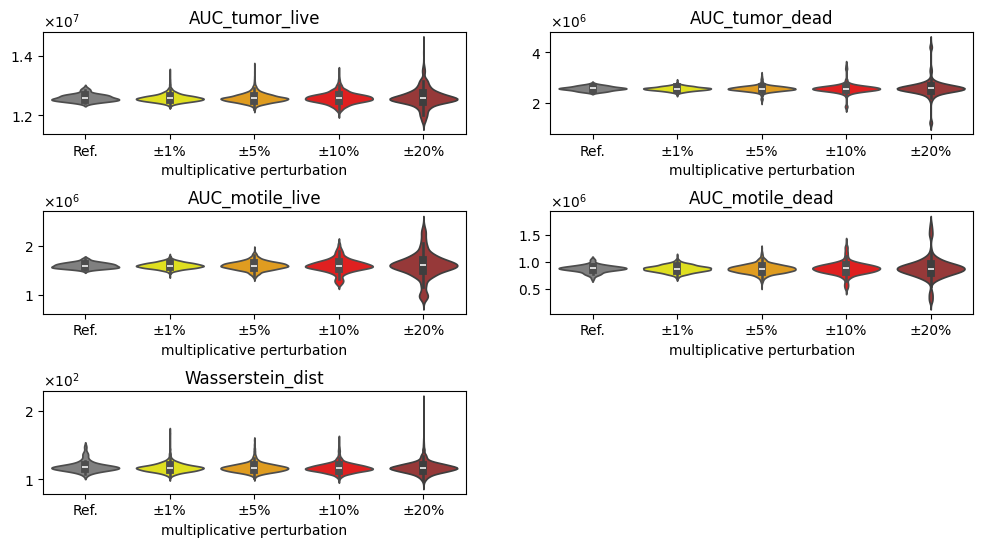

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.75)
for qoi, ax in zip(QoIs_list, axes.flatten()):
    # Plot a box plot for each QoI (x axis: SA_delta, y axis: QoI value)
    # ax.boxplot([df_all[df_summary['sample'] == sample][qoi].values for sample in [sample_ref, *samples_deltap1, *samples_deltam1, *samples_deltap5, *samples_deltam5, *samples_deltap10, *samples_deltam10, *samples_deltap20, *samples_deltam20]], showfliers=False)
    for delta, color in zip([0.0, 0.01, 0.05, 0.1, 0.2], 
                            ['gray', 'yellow', 'orange', 'red', 'brown']):
        samples = df_SA[(df_SA['SA_delta'] == delta) | (df_SA['SA_delta'] == -1*delta)]['sample'].values
        values = df_qoi[df_qoi['sample'].isin(samples)][qoi[:-5]].values
        sns.violinplot(x=[delta*100]*len(values), y=values, ax=ax, color=color)
    
    # change the x ticks label adding +- sign
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(['Ref.', '±1%', '±5%', '±10%', '±20%'])
    ax.set_title(qoi[:-5])
    ax.set_xlabel('multiplicative perturbation')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True

axes[2, 1].remove()
# plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))


plt.show()

/var/folders/z0/qjtn97gj62z2_f7wmwlwkvmc0000gn/T/ipykernel_62951/1334183296.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SA["SA_delta"] = df_SA["SA_delta"] * 100


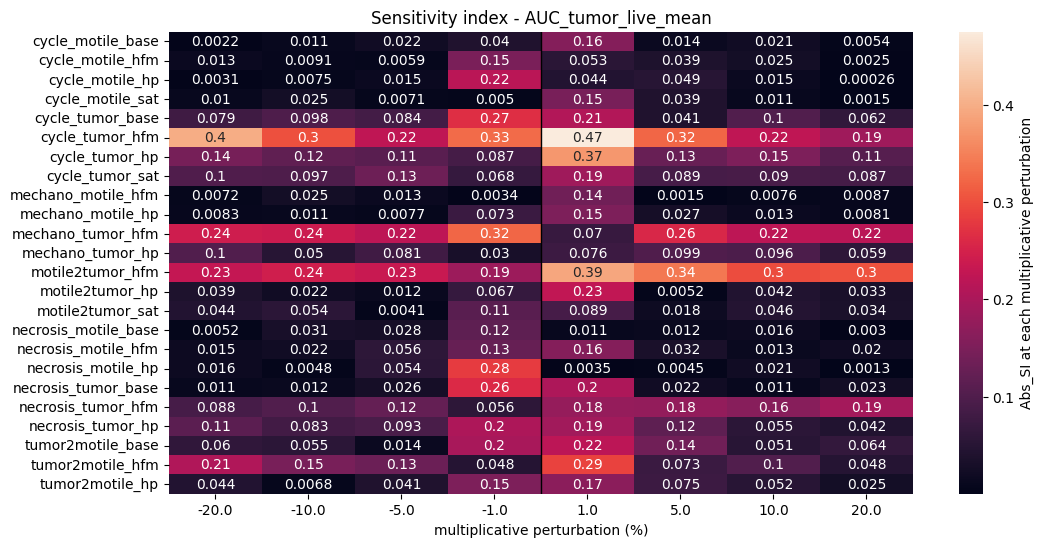

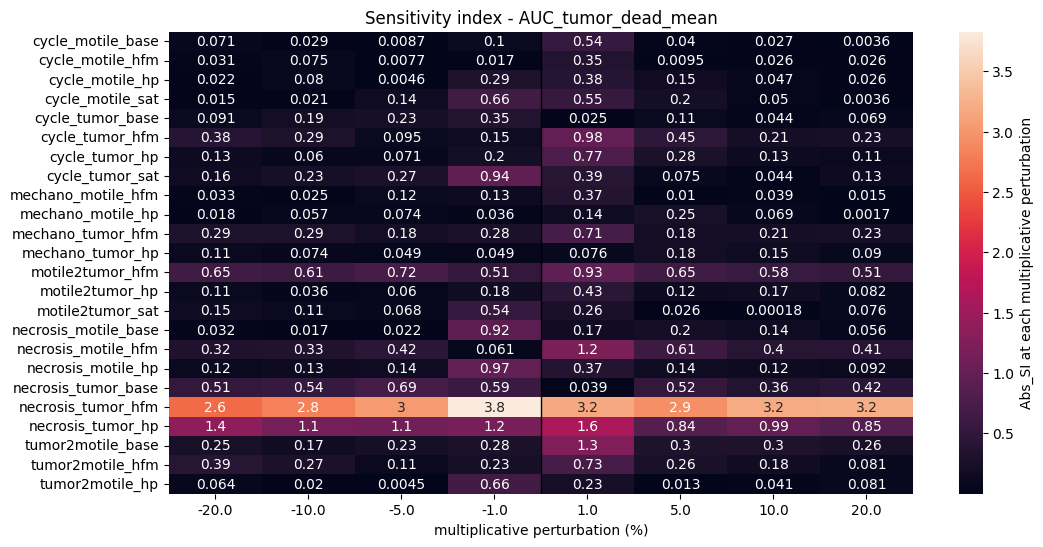

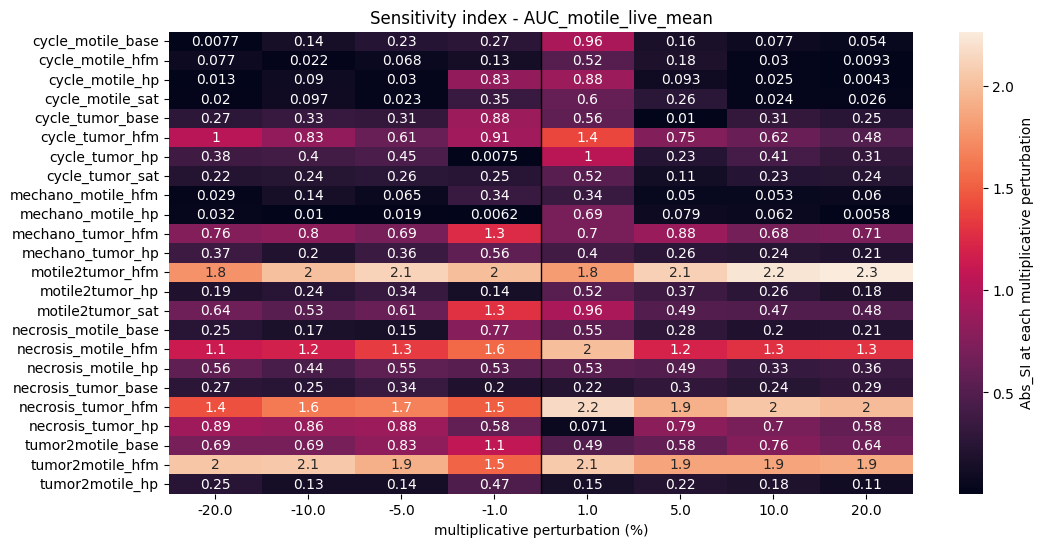

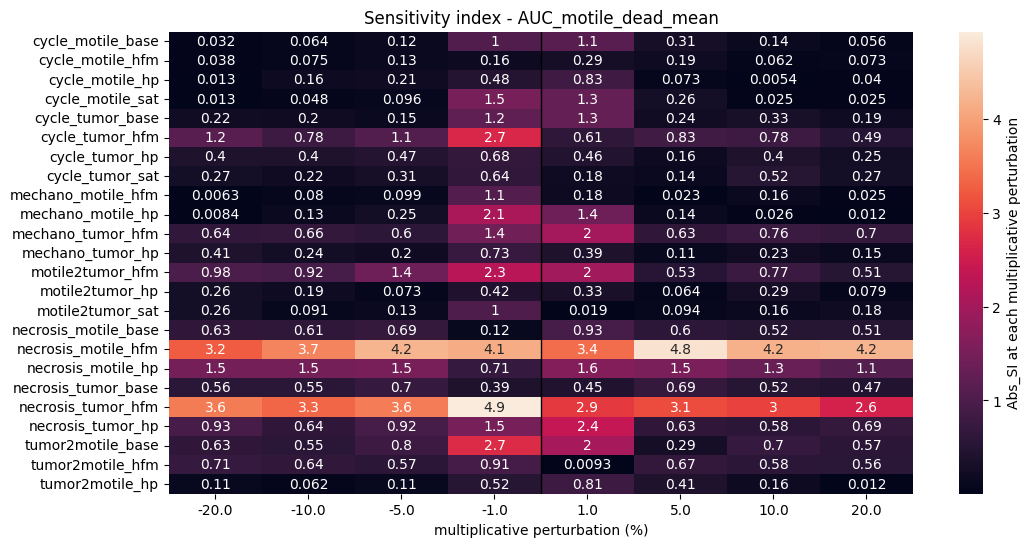

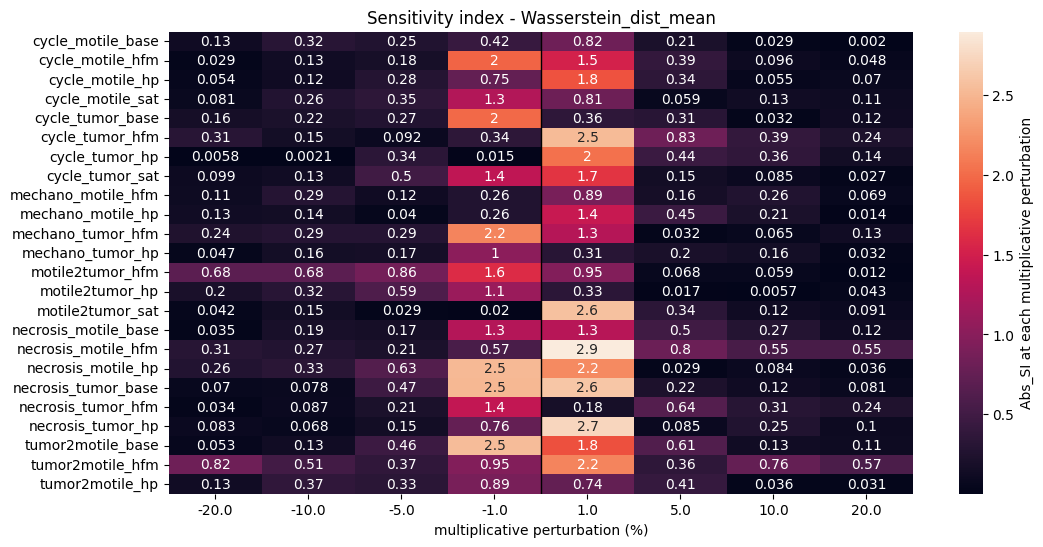

In [6]:
# Drop the reference sample
df_SA = df_SA[df_SA['sample'] != sample_ref]
# Convert the multiplicative perturbation to percentage
df_SA["SA_delta"] = df_SA["SA_delta"] * 100
plot = 'Abs_SI' # plot_options =  ["SI", "Abs_SI", 'Rank']
# Plot the parameter rank according to the relatice sensitivity index as heatmap with the parameters vs delta and color as the rank
for qoi in QoIs_list:
    fig, ax = plt.subplots(figsize=(12, 6))
    if plot == 'SI':
        # pivot the dataframe to have the parameter as index, delta as columns and sensitivity index as values
        df_SA_pivot_plot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi)
    if plot == 'Abs_SI':
        # pivot the dataframe to have the parameter as index, delta as columns and absolute sensitivity index as values
        df_SA_pivot_plot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi).abs()
    if plot == 'Rank':
        df_SA_pivot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi).abs()
        # rank of each parameter for each multiplicative perturbation ( 1 - highest sensitivity, 2 - second highest sensitivity, etc)
        df_SA_pivot_plot = df_SA_pivot.rank(axis=0, method='min', ascending=False)
    # print(df_SA_pivot.head(),'\n')
    # print(df_SA_pivot_rank.head(),'\n')
    # 
    sns.heatmap(df_SA_pivot_plot, cmap='rocket', annot=True,ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_label(f'{plot} at each multiplicative perturbation')
    # draw a line to separate the positive and negative values
    ax.axvline(4, color='black', lw=1)
    ax.set(title = f'Sensitivity index - {qoi}', xlabel='multiplicative perturbation (%)', ylabel=None)
plt.show()

# Calculate the Normalized SI in each multiplicative perturbation
$$ Normalize SI_{i,j} = \frac{SI_{i,j}}{\max SI_{.,j}},$$

where $S_{i,j}$ is the sensitivity index in each parameter $i$ and multiplicative pertubation $j$


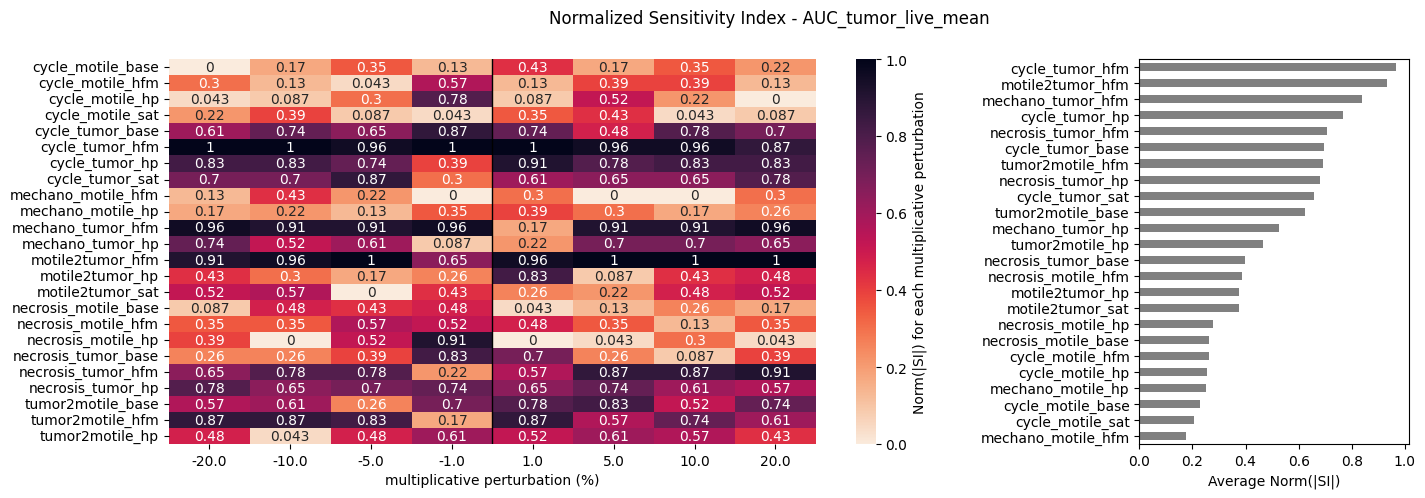

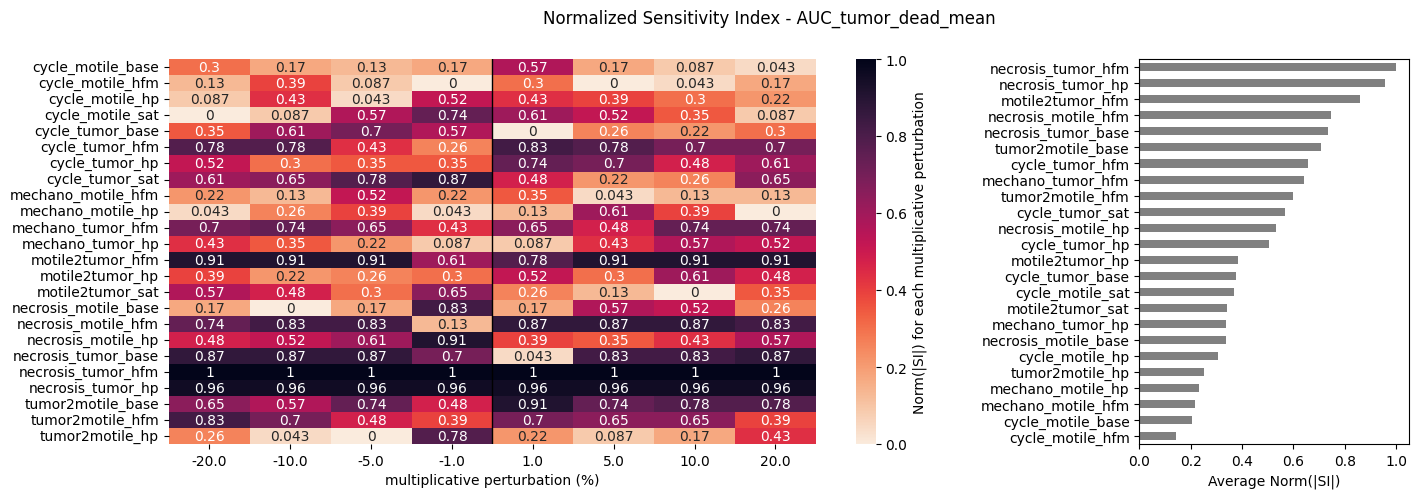

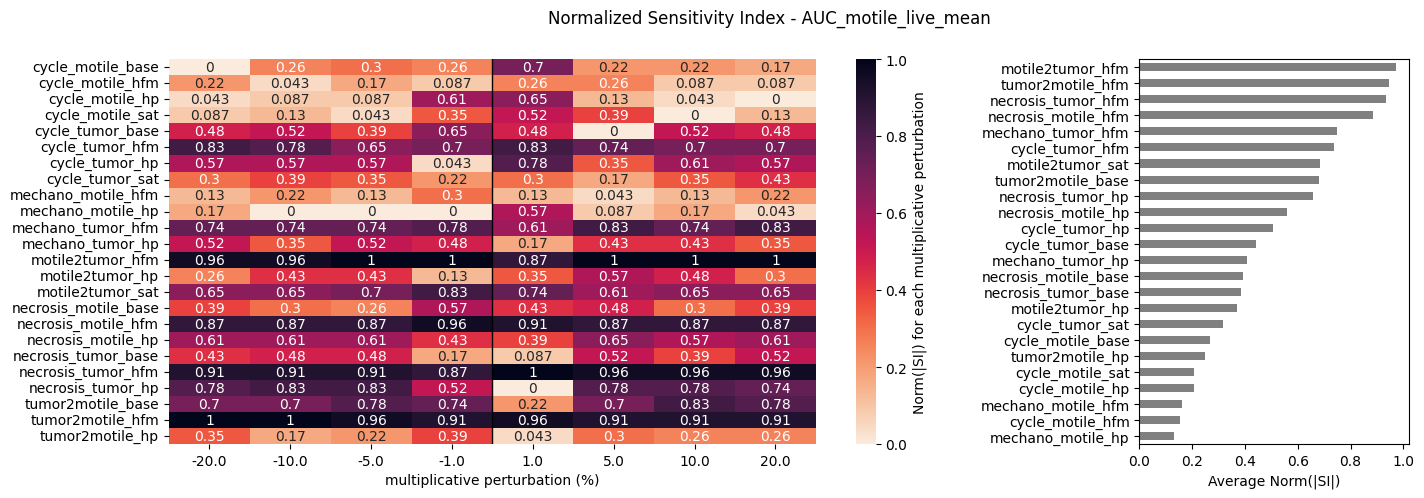

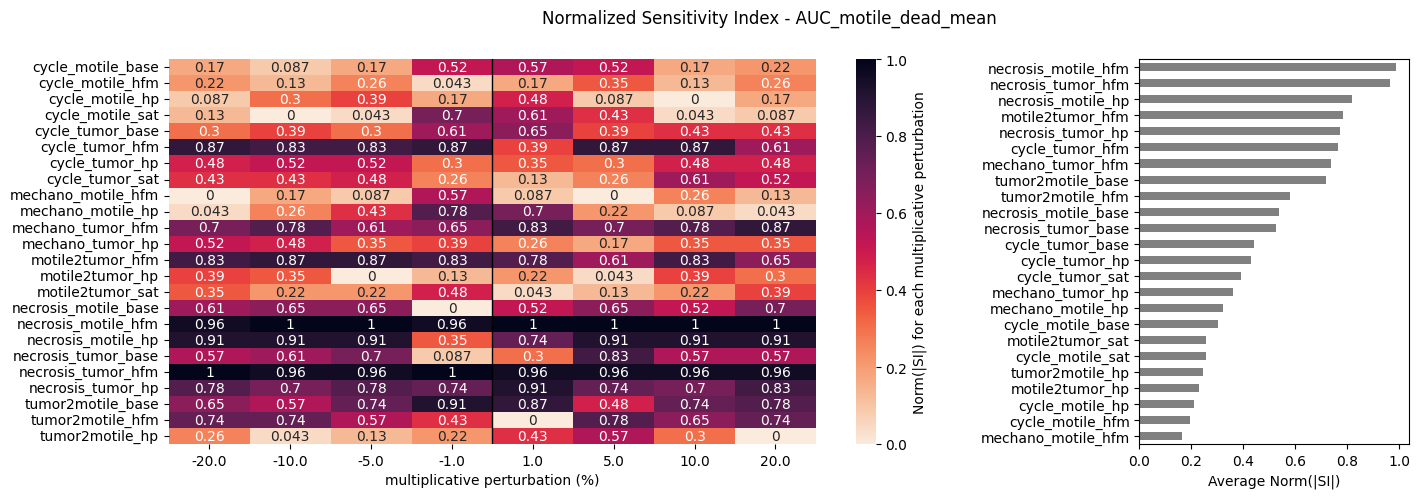

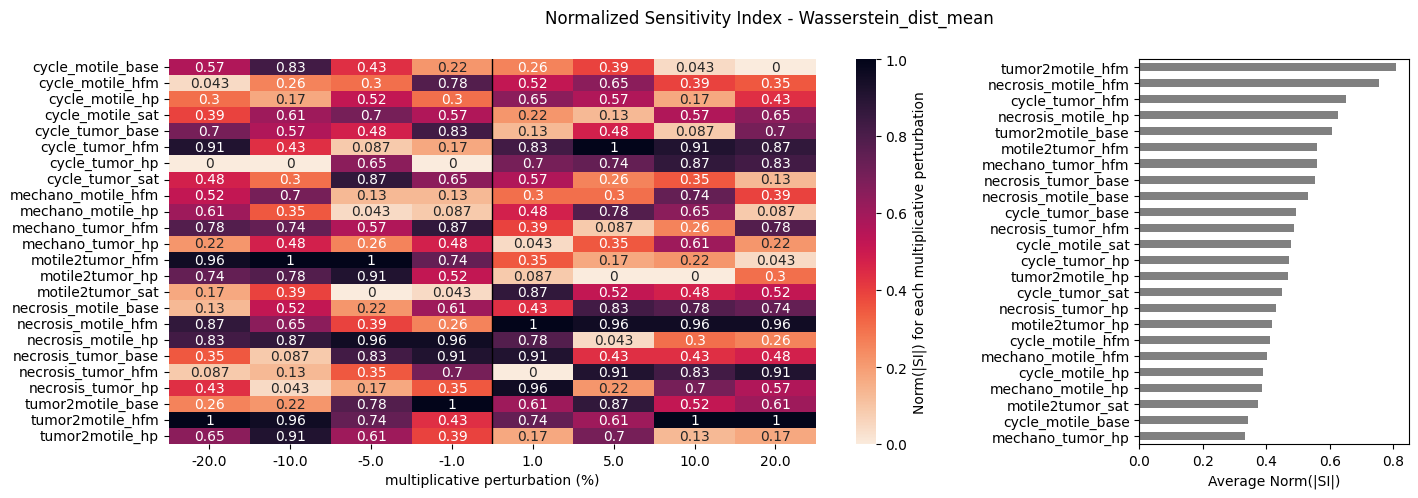

In [7]:
for qoi in QoIs_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0.3)
    fig.suptitle(f'Normalized Sensitivity Index - {qoi}')
    # Round the values to 2 decimal places
    # df_SA['SA_delta'] = df_SA['SA_delta'].round(2)
    df_SA_pivot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi).abs()
    # df of the rank of each parameter for each multiplicative perturbation
    df_SA_pivot_rank = df_SA_pivot.rank(axis=0, method='min', ascending=False)
    # convert the rank to rank sensitivity index
    df_SA_pivot_RSI = (df_SA_pivot_rank.shape[0] - df_SA_pivot_rank) / (df_SA_pivot_rank.shape[0] - 1)
    sns.heatmap(df_SA_pivot_RSI, cmap='rocket_r', annot=True,ax=ax1)
    cbar = ax1.collections[0].colorbar
    cbar.set_label('Norm(|SI|) for each multiplicative perturbation')
    ax1.set(xlabel='multiplicative perturbation (%)', ylabel=None)
    # draw a line to separate the positive and negative values
    ax1.axvline(4, color='black', lw=1)
    # Average the RSI across all multiplicative perturbations
    df_rsi_mean = df_SA_pivot_RSI.mean(axis=1)
    df_rsi_mean = df_rsi_mean.sort_values(ascending=True)
    df_rsi_mean.plot(kind='barh', ax=ax2, color='gray')
    ax2.set(xlabel='Average Norm(|SI|)', ylabel=None)